##CM3111 Assessment
#Water well logs interpretation using machine learning


##1.1	Dataset
The dataset comprises geophysical well logs data pertaining to deep water wells located in Saudi Arabia. I was an integral member of the geologists' team responsible for the collection, processing, and interpretation of these data, specifically for underground water projects spanning the period from 2012 to 2019.
The selection of this dataset is motivated by the potential it holds in offering a significant contribution to the field of geophysical water exploration.


##1.2	Related Work & Data Exploration.
#1. Dataset Overview
The dataset is a geophysical well logs records includes parameters such as natural gamma ray emissions, electric resistivity, density, temperature, spontaneous potential, and neutron counts. It is utilized for the purpose of identifying water-bearing zones within the subsurface through the interpretation of these logs. The freshwater zone exhibits distinctive characteristics in the logs, including low gamma ray emissions, a semi-linear and consistent decrease in the separation between short and long resistivity curves, and a relatively high neutron count.


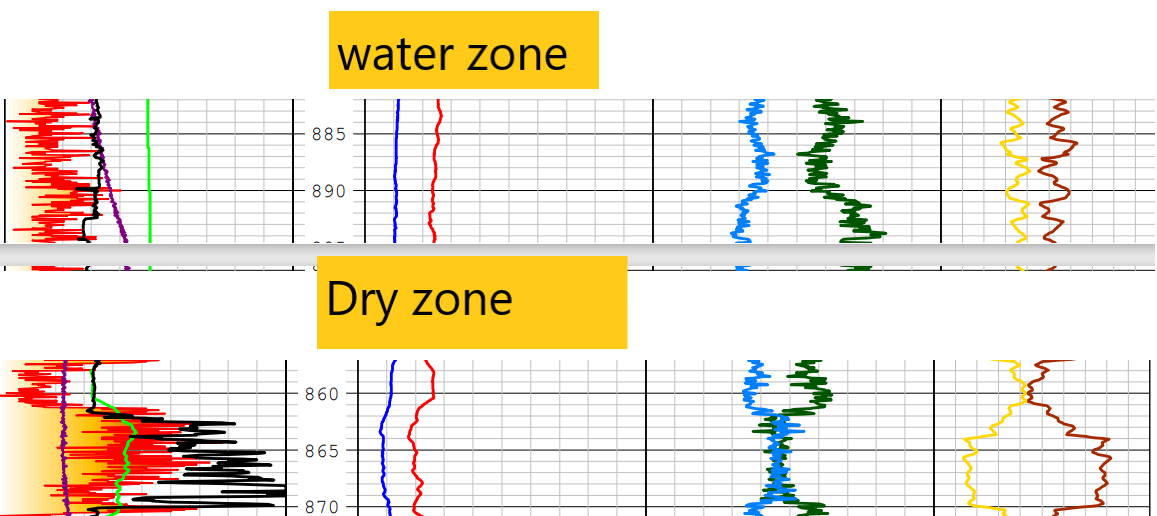

##*2*.Objectives:
The primary objective is to use this dataset  to serve as the foundation for constructing a robust Machine Learning model. This model will possess the capability to discern various log curve behaviors, enabling it to accurately pinpoint water-bearing zones within the provided well logs.


# 3.Peer-reviewed paper:

#4. Data Loading & Exploration:

In [114]:
# import required variables
import pandas as pd
import numpy as np

In [125]:
# Loading Dataset
df = pd.read_csv('/content/sample_data/WellLoging_Dataset.csv')
print(df.columns)


Index(['Well_ID', 'Depth', 'GAM(NAT)', 'RES(16N)', 'RES(64N)', 'NEUTRON',
       'Interpretation', 'Interpretation_N'],
      dtype='object')


In [116]:
# Display basic information about the dataset
print("Dataset Information:")
print(df.info())

# Display summary statistics
print("\nSummary Statistics:")
print(df.describe())

# View the first few rows of the dataset
print("\nFirst Few Rows:")
print(df.head())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30685 entries, 0 to 30684
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Well_ID           30685 non-null  object 
 1   Depth             30685 non-null  float64
 2   GAM(NAT)          30685 non-null  float64
 3   RES(16N)          30685 non-null  float64
 4   RES(64N)          30685 non-null  float64
 5   NEUTRON           30685 non-null  float64
 6   Interpretation    30685 non-null  object 
 7   Interpretation_N  30685 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 1.9+ MB
None

Summary Statistics:
              Depth      GAM(NAT)      RES(16N)      RES(64N)       NEUTRON  \
count  30685.000000  30685.000000  30685.000000  30685.000000  30685.000000   
mean     447.349076     66.606170    129.643993    253.448386    848.484463   
std      180.893172     65.838504     55.991054    148.724928    225.229816 

In [117]:
df.groupby('Interpretation').mean()

<ipython-input-117-9577cd330b70>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('Interpretation').mean()


,Depth,GAM(NAT),RES(16N),RES(64N),NEUTRON,Interpretation_N
Interpretation,,,,,,
Dry,404.919702,124.288041,71.706603,94.604321,681.340862,0.0
Water,474.973258,29.051656,167.364866,356.865829,957.305425,1.0


In [118]:
# Checking for missing values
df.isnull().sum()

Well_ID             0
Depth               0
GAM(NAT)            0
RES(16N)            0
RES(64N)            0
NEUTRON             0
Interpretation      0
Interpretation_N    0
dtype: int64

In [119]:
# Selecting the feature
df = pd.read_csv('/content/sample_data/WellLoging_Dataset.csv', usecols=['Well_ID', 'Depth','GAM(NAT)', 'RES(16N)', 'RES(64N)', 'NEUTRON',
       'Interpretation', 'Interpretation_N'])

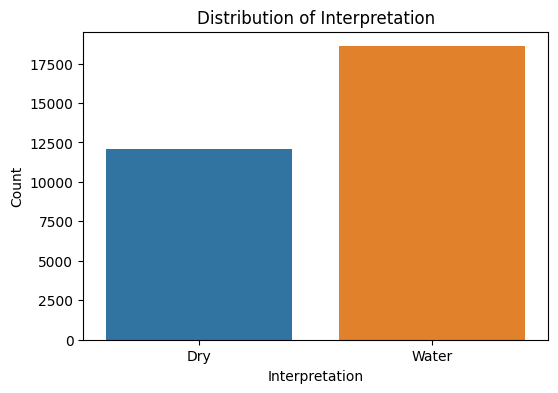

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns
# Visualize Interpretation
plt.figure(figsize=(6, 4))
sns.countplot(x='Interpretation', data=df)
plt.title('Distribution of Interpretation')
plt.xlabel('Interpretation')
plt.ylabel('Count')
plt.show()



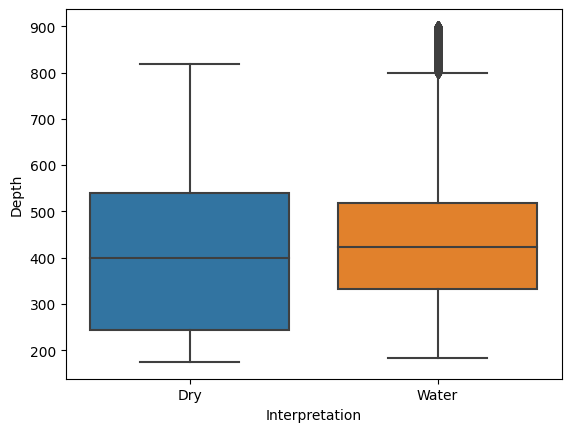

In [121]:
# Visualize Interpretation Vs Depth
sns.boxplot(data= df, x='Interpretation',y='Depth')
plt.show()


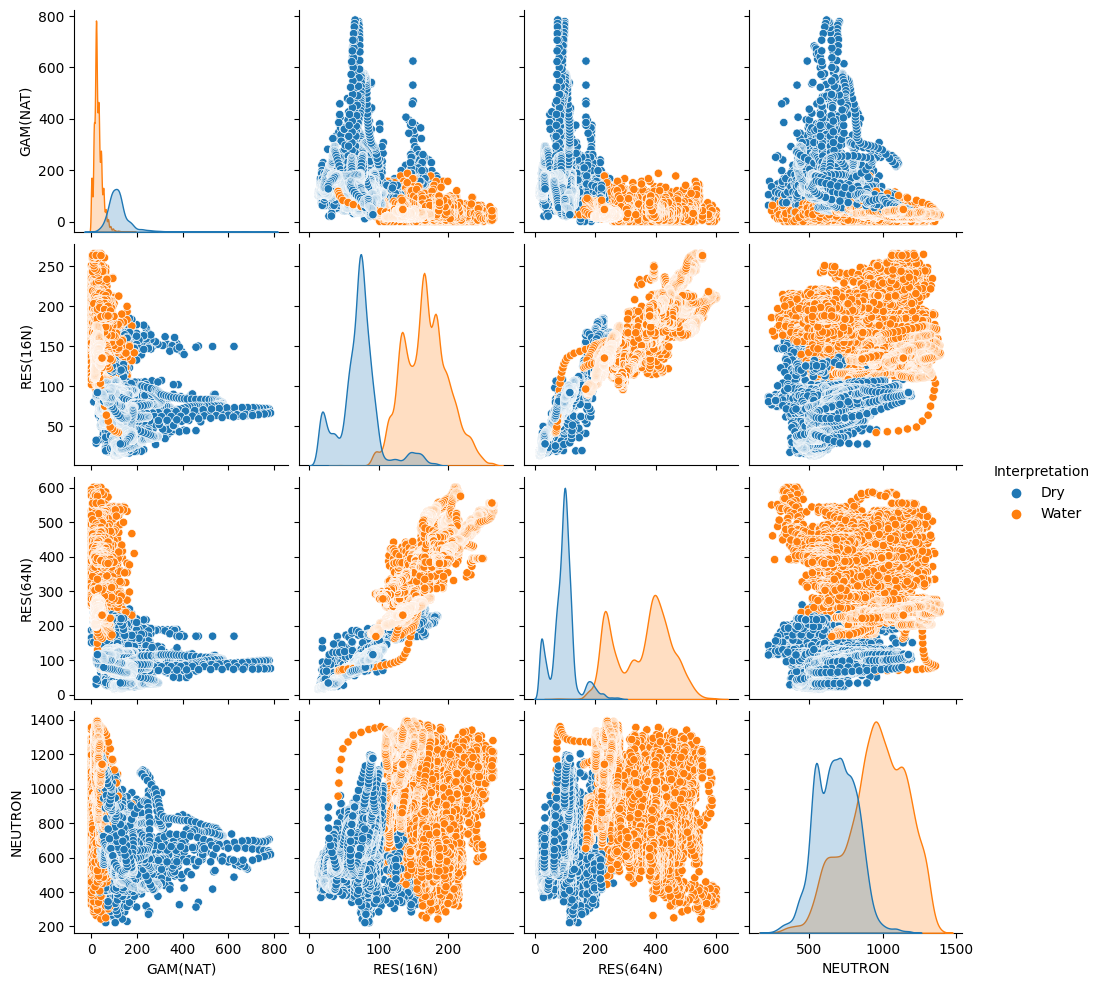

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt

# Columns to plot
cols_names = ['GAM(NAT)', 'RES(16N)', 'RES(64N)', 'NEUTRON', 'Interpretation']

# Create a pair plot
sns.pairplot(df[cols_names], hue='Interpretation')
plt.show()

[Text(0.5, 0, 'Long resistivity'), Text(0, 0.5, 'NEUTRON Counts')]

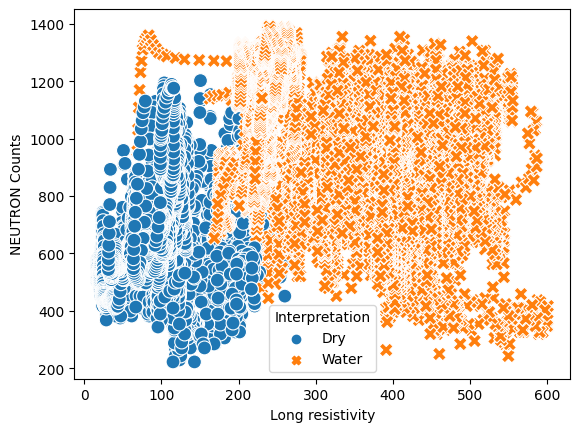

In [123]:
ax = sns.scatterplot(x='RES(64N)', y= 'NEUTRON', data=df, hue='Interpretation', style='Interpretation',s=100)
ax.set(xlabel='Long resistivity', ylabel='NEUTRON Counts')

#1.3 Data Pre-processing

"This dataset contains information for six different water wells logs. I merged them into one csv file and added a column for the well ID,  in order to prepare the data for regression modeling. I converted the outcome into a numeric value instead of a classification (Water/Dry). I replaced 'Water' with '1' and 'Dry' with '0'."

In [124]:
# data cleaning to remove outliers, as well as three different types of data scaling: Min-Max normalization, Standard Scaling (Z-Score Standardization), and Robust Scaling.

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler


def clean_and_scale_data(df, columns, threshold=3, scale_method='min_max'):
    df_clean = df.copy()

    # Remove outliers and apply scaling
    for column in columns:
        # Remove outliers using Robust Scaling
        median = df_clean[column].median()
        iqr = df_clean[column].quantile(0.75) - df_clean[column].quantile(0.25)
        z_scores = (df_clean[column] - median) / iqr
        outliers = (z_scores.abs() > threshold)
        df_clean.loc[outliers, column] = median  # Replace outliers with median

        # Apply scaling
        if scale_method == 'min_max':
            scaler = MinMaxScaler()
        elif scale_method == 'standard':
            scaler = StandardScaler()
        elif scale_method == 'robust':
            scaler = RobustScaler()
        else:
            raise ValueError("Invalid scale_method. Use 'min_max', 'standard', or 'robust'.")

        df_clean[[column]] = scaler.fit_transform(df_clean[[column]])

    return df_clean


columns_to_clean = ['GAM(NAT)', 'RES(16N)', 'RES(64N)', 'NEUTRON']
df_clean_min_max = clean_and_scale_data(df, columns_to_clean, scale_method='min_max')

df_clean_standard = clean_and_scale_data(df, columns_to_clean, scale_method='standard')

df_clean_robust = clean_and_scale_data(df, columns_to_clean, scale_method='robust')




#2 Modelling

In [175]:
# the dataset should have 6 well, to confirm that by call the unique() Function
df['Well_ID'].unique()

array(['1-T-209', '1-T-210', '1-T-211', '1-T-112', '1-T-213', '1-T-202'],
      dtype=object)

In [127]:
# Deviding dataset to training & testing
training_wells = (['1-T-210', '1-T-209', '1-T-112', '1-T-213', '1-T-202'])
testing_well = ([ '1-T-211'])

In [128]:
# extract the data from the dataset for training and testing
from sklearn.model_selection import train_test_split
train_val_df = df[df['Well_ID'].isin(training_wells)].copy()
test_df = df[df['Well_ID'].isin(testing_well)].copy()

# 2.1 Logistic Regression Model

# 2.1.1 Selecting the features


In [176]:
from sklearn.linear_model import LogisticRegression

# Selecting training & target features
X = train_val_df[['GAM(NAT)', 'RES(16N)', 'RES(64N)', 'NEUTRON']]
y = train_val_df[['Interpretation']]

# seperating the dataset into training and validation data
X_train, X_val, y_train, y_val =train_test_split(X, y, test_size=0.2)


# 2.1.2  Initialize & Train the model


In [177]:
# Initialize the logistic regression model
logRegModel = LogisticRegression()

# Train the model
logRegModel.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

# 2.1.3 Evaluare the model with validation data


In [178]:
# Predict on the validation set
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools

y_val_predicted= logRegModel.predict(X_val)


In [179]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_predicted)

# Calculate metrics
total = conf_matrix.sum()
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / total
misclassification_rate = (conf_matrix[0, 1] + conf_matrix[1, 0]) / total
true_positive_rate = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
false_positive_rate = conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[0, 0])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
report_actual = classification_report(y_val, y_val_predicted)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Misclassification Rate: {misclassification_rate:.4f}')
print(f'True Positive Rate (Sensitivity or Recall): {true_positive_rate:.4f}')
print(f'False Positive Rate: {false_positive_rate:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Actual Test Classification Report:\n{report_actual}')


Accuracy: 0.9910
Misclassification Rate: 0.0090
True Positive Rate (Sensitivity or Recall): 0.9907
False Positive Rate: 0.0086
Specificity: 0.9914
Precision: 0.9941
Actual Test Classification Report:
              precision    recall  f1-score   support

         Dry       0.99      0.99      0.99      2217
       Water       0.99      0.99      0.99      3233

    accuracy                           0.99      5450
   macro avg       0.99      0.99      0.99      5450
weighted avg       0.99      0.99      0.99      5450



(0.0, 2.0)

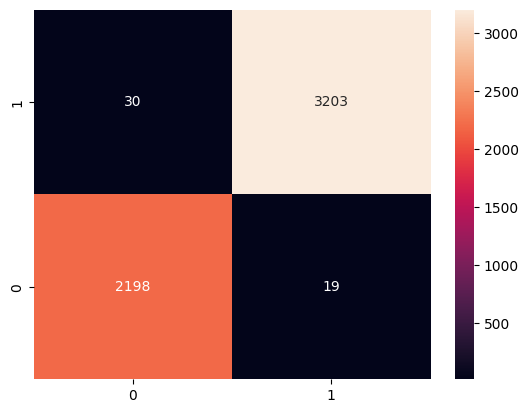

In [180]:
# Visualize the confusion matrix
ax = sns.heatmap(confusion_matrix(y_val, y_val_predicted),annot=True,fmt="d")
ax.set_ylim([0,2])

# 2.1.4 Testing the model with test data

In [181]:

test_well_x = test_df[[ 'GAM(NAT)', 'RES(16N)', 'RES(64N)', 'NEUTRON']]
test_df['TEST_DT'] = logRegModel.predict(test_well_x)

# Evaluate the model on the  test set
y_actual = test_df['Interpretation']
y_predicted = test_df['TEST_DT']

In [182]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_actual, y_predicted)

# Calculate metrics
total = conf_matrix.sum()
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / total
misclassification_rate = (conf_matrix[0, 1] + conf_matrix[1, 0]) / total
true_positive_rate = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
false_positive_rate = conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[0, 0])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
report_actual = classification_report(y_actual, y_predicted)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Misclassification Rate: {misclassification_rate:.4f}')
print(f'True Positive Rate (Sensitivity or Recall): {true_positive_rate:.4f}')
print(f'False Positive Rate: {false_positive_rate:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Actual Test Classification Report:\n{report_actual}')

Accuracy: 0.9927
Misclassification Rate: 0.0073
True Positive Rate (Sensitivity or Recall): 0.9921
False Positive Rate: 0.0051
Specificity: 0.9949
Precision: 0.9985
Actual Test Classification Report:
              precision    recall  f1-score   support

         Dry       0.97      0.99      0.98       786
       Water       1.00      0.99      1.00      2650

    accuracy                           0.99      3436
   macro avg       0.99      0.99      0.99      3436
weighted avg       0.99      0.99      0.99      3436



(0.0, 2.0)

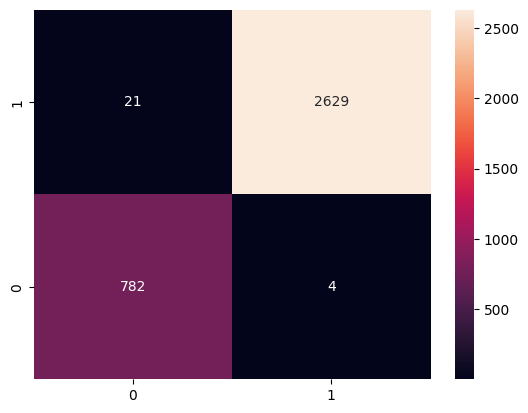

In [183]:
# Visualize the confusion matrix
ax = sns.heatmap(confusion_matrix(y_actual, y_predicted),annot=True,fmt="d")
ax.set_ylim([0,2])

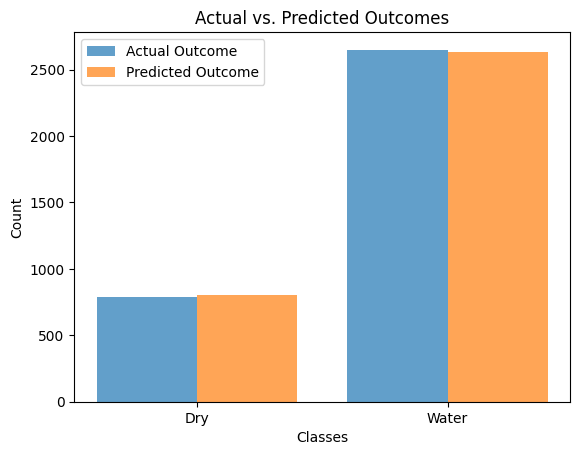

In [184]:
# create a bar plot to compare the actual and predicted outcomes
# Create an array of unique classes
classes = test_df['Interpretation'].unique()

# Count the occurrences of each class in y_actual and y_predicted
actual_counts = [sum(y_actual == cls) for cls in classes]
predicted_counts = [sum(y_predicted == cls) for cls in classes]

# Set up the positions of the bars and their width
x = range(len(classes))
width = 0.4

# Create the bar plots
plt.bar(x, actual_counts, width, label='Actual Outcome', align='center', alpha=0.7)
plt.bar([i + width for i in x], predicted_counts, width, label='Predicted Outcome', align='center', alpha=0.7)

# Set labels, title, and legend
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Actual vs. Predicted Outcomes')
plt.xticks([i + width/2 for i in x], classes)
plt.legend()

# Show the plot
plt.show()

# 2.2 Support Vector Machines (SVM)

# 2.2.1 Selecting the features


In [185]:
from sklearn.svm import LinearSVC

# Selecting training & target features
X = train_val_df[['GAM(NAT)', 'RES(16N)', 'RES(64N)', 'NEUTRON']]
y = train_val_df[['Interpretation']]

# seperating the dataset into training and validation data
X_train, X_val, y_train, y_val =train_test_split(X, y, test_size=0.2)


# 2.2.2  Initialize & Train the model


In [186]:
# Initialize the LinearSVC model
svm_model = LinearSVC()

# Train the model
svm_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

# 2.2.3 Evaluare the model with validation data


In [187]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools

y_val_pred = svm_model.predict(X_val)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Calculate metrics
total = conf_matrix.sum()
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / total
misclassification_rate = (conf_matrix[0, 1] + conf_matrix[1, 0]) / total
true_positive_rate = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
false_positive_rate = conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[0, 0])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
report_actual = classification_report(y_val, y_val_pred)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Misclassification Rate: {misclassification_rate:.4f}')
print(f'True Positive Rate (Sensitivity or Recall): {true_positive_rate:.4f}')
print(f'False Positive Rate: {false_positive_rate:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Actual Test Classification Report:\n{report_actual}')


Accuracy: 0.9914
Misclassification Rate: 0.0086
True Positive Rate (Sensitivity or Recall): 0.9940
False Positive Rate: 0.0124
Specificity: 0.9876
Precision: 0.9912
Actual Test Classification Report:
              precision    recall  f1-score   support

         Dry       0.99      0.99      0.99      2265
       Water       0.99      0.99      0.99      3185

    accuracy                           0.99      5450
   macro avg       0.99      0.99      0.99      5450
weighted avg       0.99      0.99      0.99      5450



(0.0, 2.0)

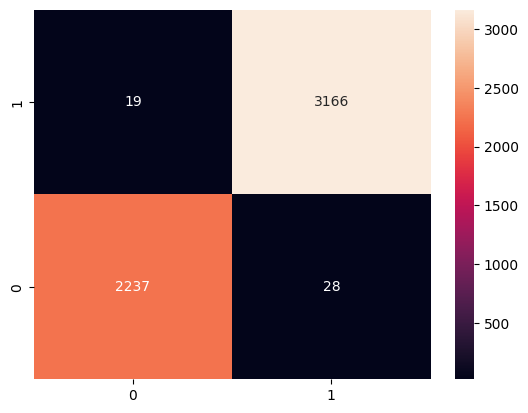

In [188]:
# Visualize the confusion matrix
ax = sns.heatmap(confusion_matrix(y_val, y_val_pred),annot=True,fmt="d")
ax.set_ylim([0,2])

# 2.2.4 Testing the model with test data

In [189]:
# Testing the model on selected test well
test_well_x = test_df[['GAM(NAT)', 'RES(16N)', 'RES(64N)', 'NEUTRON']]
test_df['TEST_DT'] = svm_model.predict(test_well_x)

# Evaluate the model on the  test set
y_actual = test_df['Interpretation']
y_predicted = test_df['TEST_DT']

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_actual, y_predicted)

# Calculate metrics
total = conf_matrix.sum()
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / total
misclassification_rate = (conf_matrix[0, 1] + conf_matrix[1, 0]) / total
true_positive_rate = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
false_positive_rate = conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[0, 0])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
report_actual = classification_report(y_actual, y_predicted)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Misclassification Rate: {misclassification_rate:.4f}')
print(f'True Positive Rate (Sensitivity or Recall): {true_positive_rate:.4f}')
print(f'False Positive Rate: {false_positive_rate:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Actual Test Classification Report:\n{report_actual}')


Accuracy: 0.9860
Misclassification Rate: 0.0140
True Positive Rate (Sensitivity or Recall): 0.9883
False Positive Rate: 0.0216
Specificity: 0.9784
Precision: 0.9936
Actual Test Classification Report:
              precision    recall  f1-score   support

         Dry       0.96      0.98      0.97       786
       Water       0.99      0.99      0.99      2650

    accuracy                           0.99      3436
   macro avg       0.98      0.98      0.98      3436
weighted avg       0.99      0.99      0.99      3436



(0.0, 2.0)

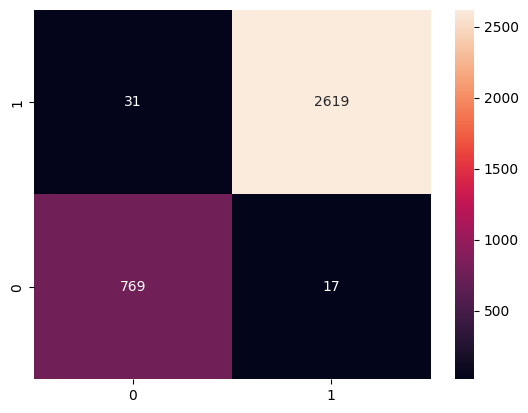

In [190]:
# Visualize the confusion matrix
ax = sns.heatmap(confusion_matrix(y_actual, y_predicted),annot=True,fmt="d")
ax.set_ylim([0,2])

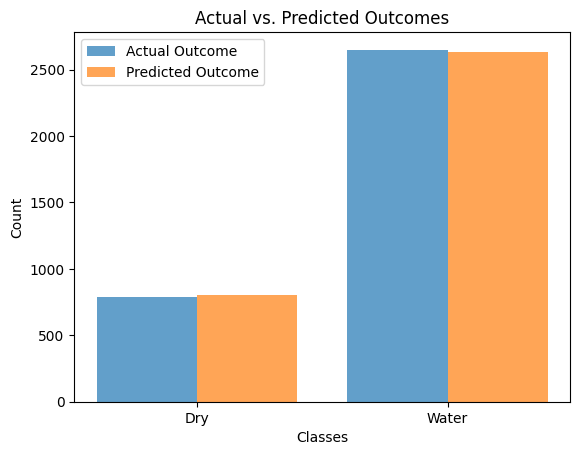

In [191]:

# create a bar plot to compare the actual and predicted outcomes
# Create an array of unique classes
classes = test_df['Interpretation'].unique()

# Count the occurrences of each class in y_actual and y_predicted
actual_counts = [sum(y_actual == cls) for cls in classes]
predicted_counts = [sum(y_predicted == cls) for cls in classes]

# Set up the positions of the bars and their width
x = range(len(classes))
width = 0.4

# Create the bar plots
plt.bar(x, actual_counts, width, label='Actual Outcome', align='center', alpha=0.7)
plt.bar([i + width for i in x], predicted_counts, width, label='Predicted Outcome', align='center', alpha=0.7)

# Set labels, title, and legend
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Actual vs. Predicted Outcomes')
plt.xticks([i + width/2 for i in x], classes)
plt.legend()

# Show the plot
plt.show()

# 2.3 Decision Tree Model

# 2.3.1 Selecting the features

In [193]:
# the dataset should have 6 well, to confirm that by call the unique() Function
df['Well_ID'].unique()

array(['1-T-209', '1-T-210', '1-T-211', '1-T-112', '1-T-213', '1-T-202'],
      dtype=object)

In [194]:
# Deviding dataset to training & testing
training_wells = (['1-T-210', '1-T-209', '1-T-112', '1-T-202', '1-T-213'])
testing_well = ([ '1-T-211'])

In [195]:
# extract the data from the dataset for training and testing
from sklearn.model_selection import train_test_split
train_val_df = df[df['Well_ID'].isin(training_wells)].copy()
test_df = df[df['Well_ID'].isin(testing_well)].copy()

In [196]:
from sklearn.model_selection import train_test_split
# Selecting training & target features
X = train_val_df[['GAM(NAT)', 'RES(16N)', 'RES(64N)', 'NEUTRON']]
y = train_val_df[['Interpretation']]

# seperating the dataset into training and validation data
X_train, X_val, y_train, y_val =train_test_split(X, y, test_size=0.2)

# 2.3.2 Initialize & Train the mode

In [197]:
from sklearn.tree import DecisionTreeClassifier
 # create an instance of the decision tree model
clf = DecisionTreeClassifier(max_depth = 2,
random_state = 0)
 # train the model
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=0)

# 2.3.3 Evaluare the model with validation data

In [198]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools

y_val_pred = svm_model.predict(X_val)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Calculate metrics
total = conf_matrix.sum()
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / total
misclassification_rate = (conf_matrix[0, 1] + conf_matrix[1, 0]) / total
true_positive_rate = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
false_positive_rate = conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[0, 0])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
report_actual = classification_report(y_val, y_val_pred)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Misclassification Rate: {misclassification_rate:.4f}')
print(f'True Positive Rate (Sensitivity or Recall): {true_positive_rate:.4f}')
print(f'False Positive Rate: {false_positive_rate:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Actual Test Classification Report:\n{report_actual}')

Accuracy: 0.9896
Misclassification Rate: 0.0104
True Positive Rate (Sensitivity or Recall): 0.9917
False Positive Rate: 0.0133
Specificity: 0.9867
Precision: 0.9902
Actual Test Classification Report:
              precision    recall  f1-score   support

         Dry       0.99      0.99      0.99      2335
       Water       0.99      0.99      0.99      3148

    accuracy                           0.99      5483
   macro avg       0.99      0.99      0.99      5483
weighted avg       0.99      0.99      0.99      5483



(0.0, 2.0)

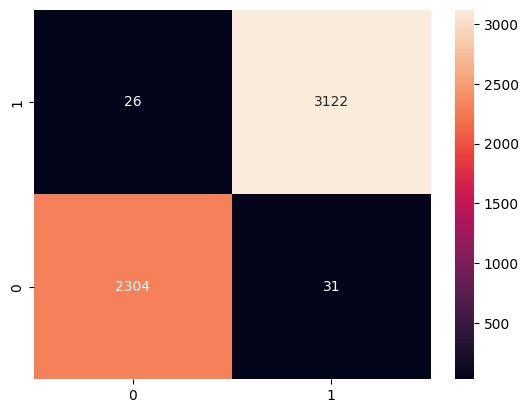

In [199]:
# Visualize the confusion matrix
ax = sns.heatmap(confusion_matrix(y_val, y_val_pred),annot=True,fmt="d")
ax.set_ylim([0,2])

# 2.3.4 Testing the model with test data

In [200]:
# Testing the model on selected test well
test_well_x = test_df[['GAM(NAT)', 'RES(16N)', 'RES(64N)', 'NEUTRON']]
test_df['TEST_DT'] = svm_model.predict(test_well_x)

# Evaluate the model on the  test set
y_actual = test_df['Interpretation']
y_predicted = test_df['TEST_DT']

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_actual, y_predicted)

# Calculate metrics
total = conf_matrix.sum()
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / total
misclassification_rate = (conf_matrix[0, 1] + conf_matrix[1, 0]) / total
true_positive_rate = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
false_positive_rate = conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[0, 0])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
report_actual = classification_report(y_actual, y_predicted)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Misclassification Rate: {misclassification_rate:.4f}')
print(f'True Positive Rate (Sensitivity or Recall): {true_positive_rate:.4f}')
print(f'False Positive Rate: {false_positive_rate:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Actual Test Classification Report:\n{report_actual}')

Accuracy: 0.9872
Misclassification Rate: 0.0128
True Positive Rate (Sensitivity or Recall): 1.0000
False Positive Rate: 0.1317
Specificity: 0.8683
Precision: 0.9860
Actual Test Classification Report:
              precision    recall  f1-score   support

         Dry       1.00      0.87      0.93       319
       Water       0.99      1.00      0.99      2952

    accuracy                           0.99      3271
   macro avg       0.99      0.93      0.96      3271
weighted avg       0.99      0.99      0.99      3271



(0.0, 2.0)

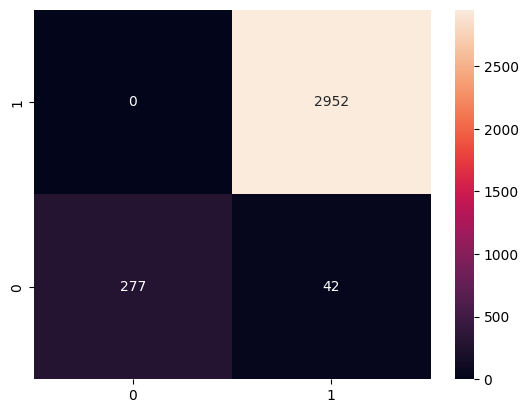

In [201]:
# Visualize the confusion matrix
ax = sns.heatmap(confusion_matrix(y_actual, y_predicted),annot=True,fmt="d")
ax.set_ylim([0,2])

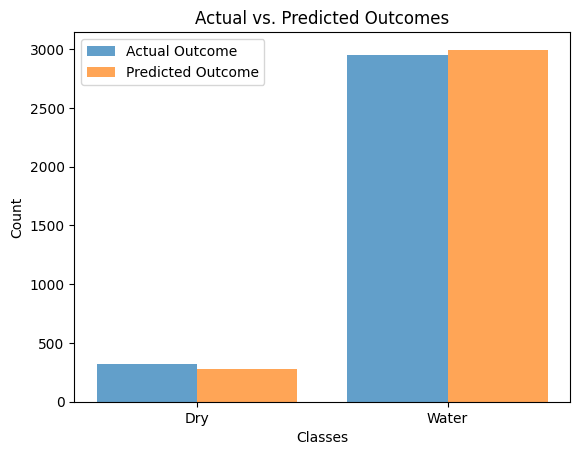

In [202]:
# create a bar plot to compare the actual and predicted outcomes
# Create an array of unique classes
classes = test_df['Interpretation'].unique()

# Count the occurrences of each class in y_actual and y_predicted
actual_counts = [sum(y_actual == cls) for cls in classes]
predicted_counts = [sum(y_predicted == cls) for cls in classes]

# Set up the positions of the bars and their width
x = range(len(classes))
width = 0.4

# Create the bar plots
plt.bar(x, actual_counts, width, label='Actual Outcome', align='center', alpha=0.7)
plt.bar([i + width for i in x], predicted_counts, width, label='Predicted Outcome', align='center', alpha=0.7)

# Set labels, title, and legend
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Actual vs. Predicted Outcomes')
plt.xticks([i + width/2 for i in x], classes)
plt.legend()

# Show the plot
plt.show()